# Classification

Note book to view classification results.

First import libraries

In [2]:
from decouple import config
import os
import seaborn as sns
sns.set_style('darkgrid')
import pandas as pd
from nilearn import datasets, plotting, image 
from fNeuro.connectivity.connectivity import Cyclic_analysis, connectome_plotting, cyclic_order, get_correlation_long_df, get_mean_correlation_matrix, order_networks
import fNeuro.processing.processing as processing
from fNeuro.bayesian.bayesian import z_score_to_bayes_factor, logistic_to_bayes_factor 
from fNeuro.utils.pickling import load_pickle
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

Get time series 

In [3]:
resting_path = config('resting')
time_series = load_pickle(os.path.join(resting_path, 'measures', 'time_series'))
an_time_series = list(time_series['an'].values())
hc_time_series = list(time_series['hc'].values())
msdl = datasets.fetch_atlas_msdl()
msdl_overview_df = pd.DataFrame({'labels': msdl['labels'],
                                  'networks': msdl['networks'],
                                  'region_coords': msdl['region_coords']
                                  })

Concat time series into one array and build labels. 0 is AN, 1 is HC

In [4]:
group = np.asarray(an_time_series + hc_time_series)
label = np.asarray([0 for sub in range(len(an_time_series))] + [1 for sub in range(len(hc_time_series))])

Plot an example of a time series

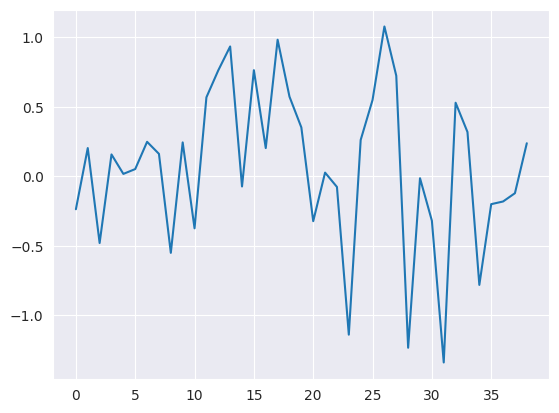

In [5]:
plt.plot(an_time_series[0][3])
plt.show()

## Get the most accurate model

Load in the models from memory

In [6]:
connectome = load_pickle(os.path.join(resting_path, 'measures', 'connectome'))
svc = load_pickle(os.path.join(resting_path, 'measures', 'svc_model'))
logistic = load_pickle(os.path.join(resting_path, 'measures', 'logistic_model'))
random_forest = load_pickle(os.path.join(resting_path, 'measures', 'random_forest_model'))
dec_tree = load_pickle(os.path.join(resting_path, 'measures', 'tree_model'))
stacked = load_pickle(os.path.join(resting_path, 'measures', 'stacked_model'))

Plot the accuracy of all  ml models

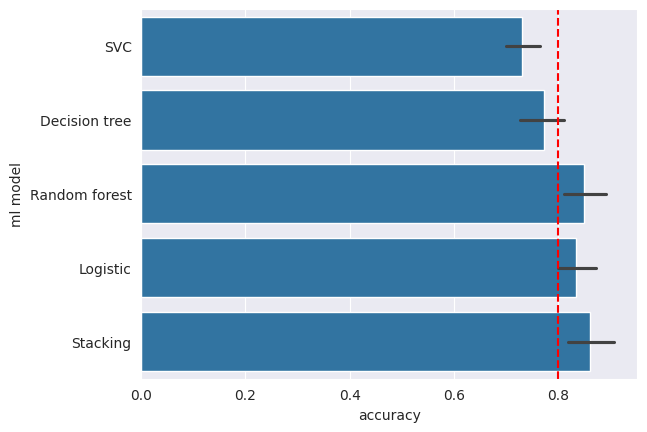

In [7]:
overal_score = {'Accuracy': pd.DataFrame(data={
                                                'SVC': svc['Accuracy'],
                                                'Decision tree': dec_tree['Accuracy'],
                                                'Random forest': random_forest['Accuracy'],
                                                'Logistic': logistic['Accuracy'],
                                                'Stacking': stacked['Accuracy'],
                                                }),
                'AUC': pd.DataFrame(data={
                                                'SVC': svc['ROC_AUC'],
                                                'Decision tree': dec_tree['ROC_AUC'],
                                                'Random forest': random_forest['ROC_AUC'],
                                                'Logistic': logistic['ROC_AUC'], 
                                                'Stacking': stacked['ROC_AUC']
                                                })
}

accuracy_plot = sns.barplot(data=pd.melt(overal_score['Accuracy']).rename(columns={'variable': 'ml model', 'value': 'accuracy'}), 
                   x='accuracy', y='ml model')
accuracy_plot.axvline(0.8, color="red", linestyle="--")

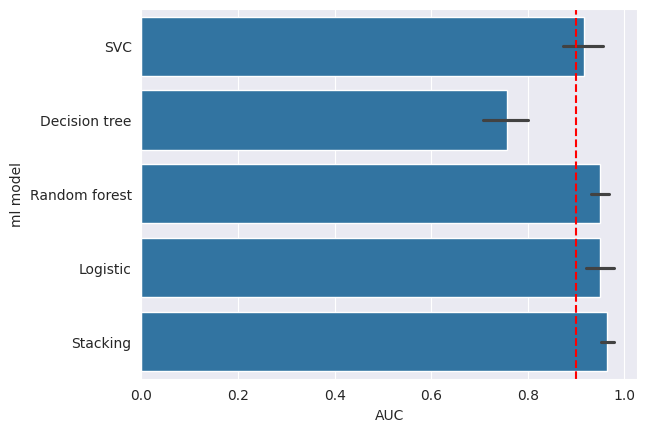

In [8]:
auc = sns.barplot(data=pd.melt(overal_score['AUC']).rename(columns={'variable': 'ml model', 'value': 'AUC'}), 
                   x='AUC', y='ml model')
auc.axvline(0.9, color="red", linestyle="--")

In [9]:
overal_score['Accuracy'].mean()

SVC              0.730769
Decision tree    0.773077
Random forest    0.850000
Logistic         0.834615
Stacking         0.861538
dtype: float64

In [10]:
overal_score['AUC'].mean()

SVC              0.917160
Decision tree    0.757692
Random forest    0.950296
Logistic         0.949704
Stacking         0.965089
dtype: float64

### Comparing cyclic analysis to other connectivity analysis

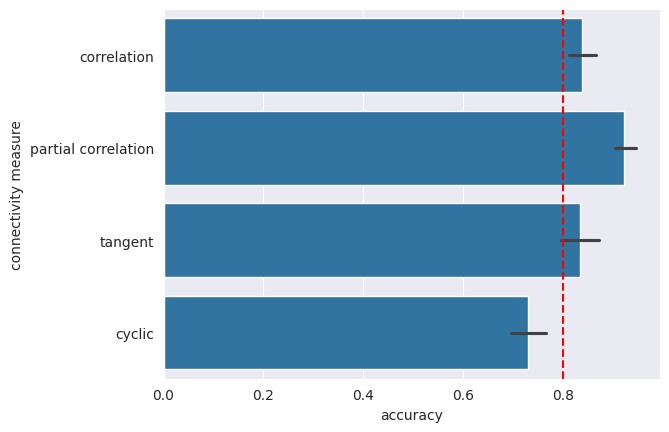

In [11]:
comp_scores = load_pickle(os.path.join(resting_path, 'measures', 'svc_comparison'))
del(comp_scores['cyclic']['model'])
comp_score_dict = {'Accuracy': pd.DataFrame(data={
                                                'correlation': comp_scores['correlation'][0]['Accuracy'],
                                                'partial correlation': comp_scores['partial correlation'][0]['Accuracy'],
                                                'tangent': comp_scores['tangent'][0]['Accuracy'],
                                                'cyclic': comp_scores['cyclic']['Accuracy'],
                                                }),
                'AUC': pd.DataFrame(data={
                                            'correlation': comp_scores['correlation'][0]['ROC_AUC'],
                                            'partial correlation': comp_scores['partial correlation'][0]['ROC_AUC'],
                                            'tangent': comp_scores['tangent'][0]['ROC_AUC'],
                                            'cyclic': comp_scores['cyclic']['ROC_AUC'],
                                                })
}

accuracy_plot = sns.barplot(data=pd.melt(comp_score_dict['Accuracy']).rename(columns={'variable': 'connectivity measure', 'value': 'accuracy'}), 
                   x='accuracy', y='connectivity measure')
accuracy_plot.axvline(0.8, color="red", linestyle="--")

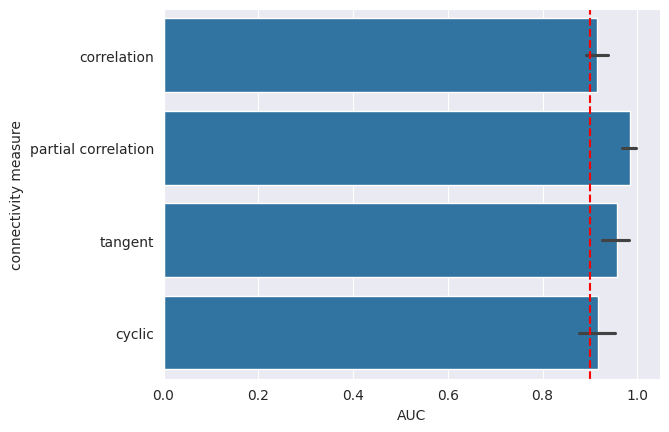

In [12]:
auc = sns.barplot(data=pd.melt(comp_score_dict['AUC']).rename(columns={'variable': 'connectivity measure', 'value': 'AUC'}), 
                   x='AUC', y='connectivity measure')
auc.axvline(0.9, color="red", linestyle="--")

### Examine weights and correlations

First get the full correlation matrix then get the mean correlations of group. Get the names of all the correlations and finally get the mean correlation values 

In [13]:
correlation_matrix = get_mean_correlation_matrix(group, msdl['labels'])
an_mean_correlations = correlation_matrix['an_mean_correlations']
hc_mean_correlations = correlation_matrix['hc_mean_correlations']

Get the correlation names, network names and values by group 

In [14]:
an_df = get_correlation_long_df(an_mean_correlations, msdl_overview_df)
hc_df = get_correlation_long_df(hc_mean_correlations, msdl_overview_df)

Get the biomarker information

In [15]:
markers_df = pd.DataFrame(data={
                            'correlation_names': an_df['corr_names'],
                            'network': an_df['network_names'],
                            'rf_importance': stacked['model'].named_estimators_.rf.feature_importances_,
                              })
markers_df['log_coeffiecents'] = stacked['model'].named_estimators_.log.coef_.T
markers_df['Bayes'] = markers_df['log_coeffiecents'].apply(lambda coef: logistic_to_bayes_factor(coef))

Segregate the biomarker dataframe by network and calculate the mean of each network and get the value for all between network nodes

In [16]:
network_values = order_networks(msdl_overview_df, markers_df, 'network')
within_network = dict(zip([network for network in msdl_overview_df['networks'].unique()], 
                          [{} for network in msdl_overview_df['networks'].unique()]))
for get_mean in network_values.keys():
    if len(network_values[get_mean]['within']) > 0:
        within_network[get_mean]['rf_importance'] = network_values[get_mean]['within']['rf_importance'].mean()
        within_network[get_mean]['log_coeffiecents'] = network_values[get_mean]['within']['log_coeffiecents'].mean()

between_network_list  =[network_values[df]['between'] for df in network_values.keys()]
between_network = pd.concat(between_network_list).reset_index(drop=True)

Get the most predicitive network

In [17]:
within_network_df = pd.DataFrame(within_network).T.dropna()
within_network_df = processing.df_with_transformed_values(within_network_df)
most_predicitive_within_network = processing.get_max_value(within_network_df)
most_predicitive_within_network['an_corr'] = an_df[an_df['network_names'].str.contains(f'{most_predicitive_within_network.index[0]} - {most_predicitive_within_network.index[0]}')]['correlation'].mean()
most_predicitive_within_network['hc_corr'] = hc_df[hc_df['network_names'].str.contains(f'{most_predicitive_within_network.index[0]} - {most_predicitive_within_network.index[0]}')]['correlation'].mean()
most_predicitive_within_network['bayes_factor'] = most_predicitive_within_network['z_score_transformation_rf'].apply(lambda bayes: z_score_to_bayes_factor(bayes))
most_predicitive_within_network

,rf_importance,log_coeffiecents,z_score_transformation_rf,z_score_transformation_log,an_corr,hc_corr,bayes_factor
Temporal,0.004007,-0.009643,2.804996,-1.826736,0.799667,-2.378782,51.111068


Within the most predicitive network nodes connection (Sometimes there is only hence why bayes factor is not calculated as z scores will be 0)

In [18]:
within_network_prediction = network_values[most_predicitive_within_network.index[0]]['within']
within_network_prediction = processing.df_with_transformed_values(within_network_prediction)
most_predicitive_within_network_node = processing.get_max_value(within_network_prediction)
most_predicitive_within_network_node['an_corr'] = an_df[an_df['corr_names'] == most_predicitive_within_network_node['correlation_names'].values[0]]['correlation'].values[0]
most_predicitive_within_network_node['hc_corr'] = hc_df[hc_df['corr_names'] == most_predicitive_within_network_node['correlation_names'].values[0]]['correlation'].values[0]
most_predicitive_within_network_node

,correlation_names,network,rf_importance,log_coeffiecents,Bayes,z_score_transformation_rf,z_score_transformation_log,an_corr,hc_corr
350,L STS - R STS,Temporal - Temporal,0.004007,-0.009643,1.000046,0.0,0.0,0.799667,-2.378782


Get the most predicitive between network connectivity nodes

In [19]:
between_network_df = processing.df_with_transformed_values(between_network)
most_predicitive_between_network = processing.get_max_value(between_network_df)
most_predicitive_between_network['an_corr'] = an_df[an_df['corr_names'] == most_predicitive_between_network['correlation_names'].values[0]]['correlation'].values[0]
most_predicitive_between_network['hc_corr'] = hc_df[hc_df['corr_names'] == most_predicitive_between_network['correlation_names'].values[0]]['correlation'].values[0]
most_predicitive_between_network['bayes_factor'] = most_predicitive_between_network['z_score_transformation_rf'].apply(lambda bayes: z_score_to_bayes_factor(bayes))
most_predicitive_between_network.drop('Bayes', axis=1)

,correlation_names,network,rf_importance,log_coeffiecents,z_score_transformation_rf,z_score_transformation_log,an_corr,hc_corr,bayes_factor
318,R Post Temp - L IPS,R V Att - D Att,0.019738,-0.022989,9.119562,-2.267695,1.581452,-5.70869,1.146455e+18


## Get the Sequential order for AN and HC

In [20]:
an_orders = cyclic_order(an_mean_correlations, 0)
an_orders

,regions,eigenvalue_moduli,leading_eigenvector,leading_eigenvector_component_phases
0,R Ins,7.360788e-16,-0.322923-0.000000j,-3.141593
1,L STS,3.482855e+00,-0.093405-0.002198j,-3.118061
2,Striate,3.020561e+01,-0.191663-0.013289j,-3.072366
3,Basal,8.912644e+00,-0.122423-0.042828j,-2.805065
4,L Aud,3.571711e+01,-0.043304-0.062434j,-2.177213
5,R TPJ,1.840047e+00,0.017940-0.044252j,-1.185626
6,R Post Temp,8.912644e+00,0.079870-0.015788j,-0.195159
7,R IPS,6.333154e+00,0.131496+0.025122j,0.188775
8,Med DMN,2.408844e+01,0.107393+0.038497j,0.344194
9,R DMN,1.949169e+01,0.055025+0.024707j,0.422043


In [21]:
hc_orders = cyclic_order(hc_mean_correlations, 0)
hc_orders

,regions,eigenvalue_moduli,leading_eigenvector,leading_eigenvector_component_phases
0,L Ant IPS,1.248335e+00,-0.031468-0.009014j,-2.862626
1,R Ant IPS,1.248335e+00,-0.000622-0.143843j,-1.575122
2,R STS,3.871021e+00,0.022447-0.181411j,-1.447687
3,L STS,4.795623e+00,0.063433-0.155206j,-1.182808
4,L Aud,5.133394e+01,0.048871-0.107742j,-1.144957
5,R Aud,5.133394e+01,0.043195-0.090752j,-1.126562
6,R IPS,7.636075e+00,0.022592-0.041049j,-1.067677
7,L IPS,1.087184e+01,0.046496-0.044867j,-0.767571
8,Motor,2.134768e+01,0.159399-0.145889j,-0.741175
9,L TPJ,3.871021e+00,0.297571-0.068238j,-0.225418


## Plot connectomes

The logistic coeffiecents are plotted for ease of visualisation 

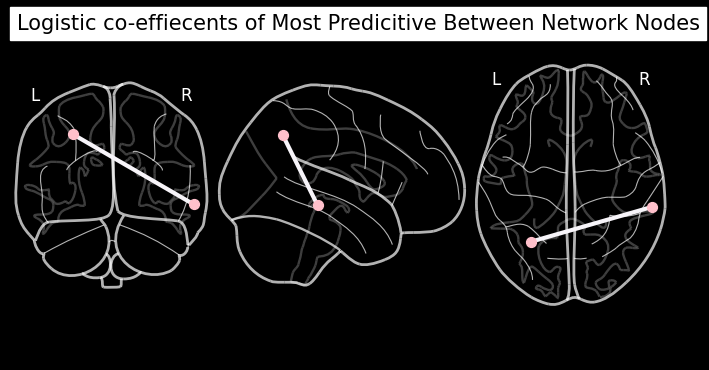

In [22]:
plot_parameters = connectome_plotting(most_predicitive_between_network, 'log_coeffiecents', msdl_overview_df)
plotting.plot_connectome(plot_parameters['adj'], 
                         plot_parameters['coords'],   
                         node_color='pink',
                         node_size=50,
                         edge_cmap='PuRd',
                         black_bg=True, 
                         title='Logistic co-effiecents of Most Predicitive Between Network Nodes')

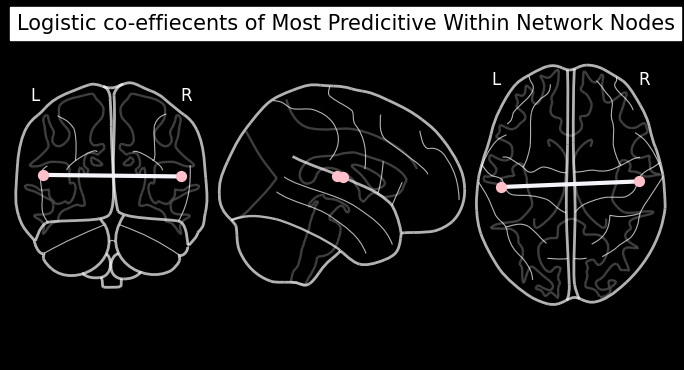

In [23]:
plot_parameters = connectome_plotting(most_predicitive_within_network_node, 'log_coeffiecents', msdl_overview_df)
plotting.plot_connectome(plot_parameters['adj'], 
                         plot_parameters['coords'],   
                         node_color='pink',
                         node_size=50,
                         edge_cmap='PuRd',
                         black_bg=True, 
                         title='Logistic co-effiecents of Most Predicitive Within Network Nodes')

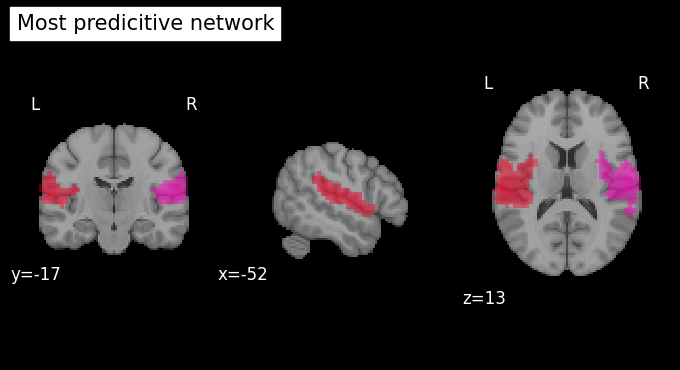

In [24]:
plotting.plot_prob_atlas(
    image.index_img(
        msdl['maps'], 
        msdl_overview_df[msdl_overview_df['networks'].str.contains(most_predicitive_within_network.index[0])].index.to_list()
        ),
    draw_cross=False,
    black_bg=True,
    cut_coords=msdl_overview_df[msdl_overview_df['networks'].str.contains(most_predicitive_within_network.index[0])]['region_coords'].to_list()[0],
    cmap='gist_rainbow',
    title='Most predicitive network'
)


Sort out the AN and HC correlations into one DataFrame 

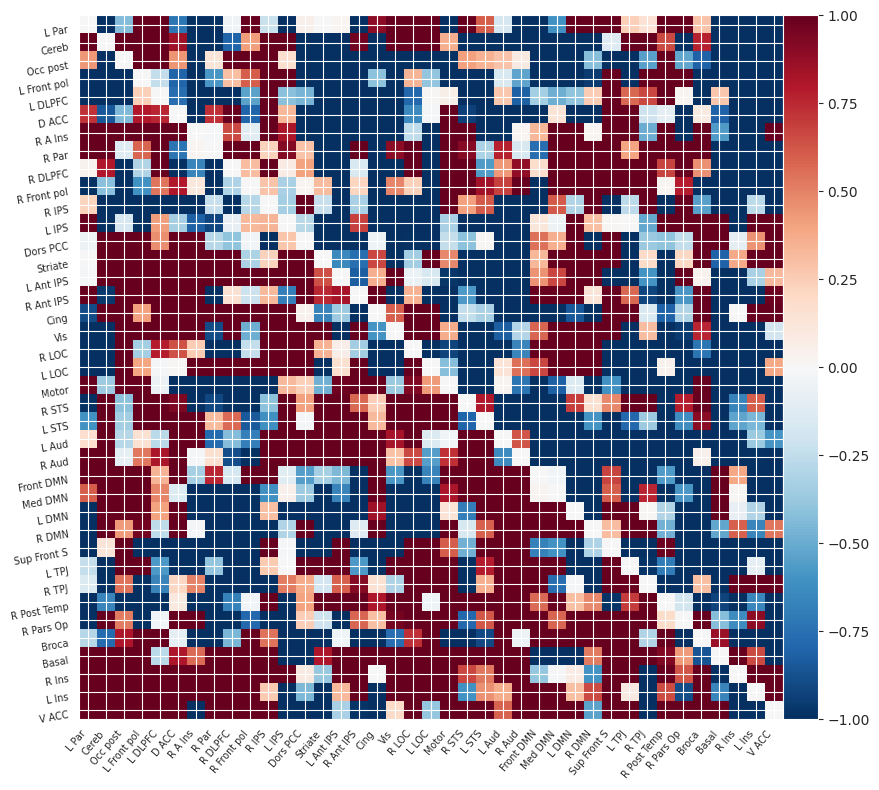

In [25]:
plotting.plot_matrix(
    an_mean_correlations.values,
    figure=(10, 8),
    labels=msdl['labels'],
    vmax=1,
    vmin=-1,
    reorder=True,
)

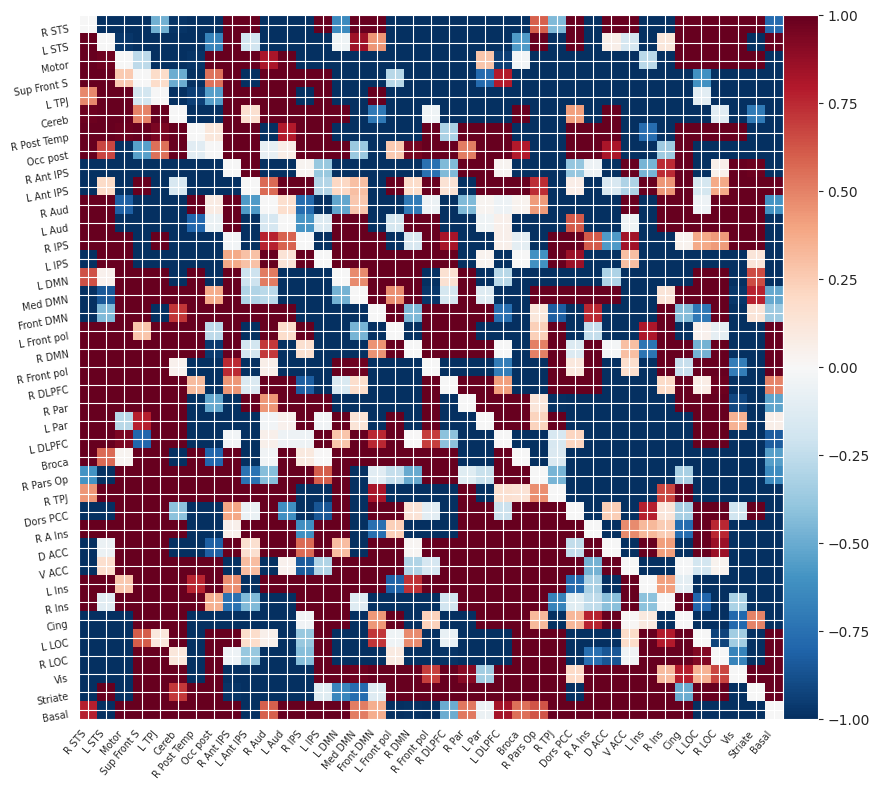

In [26]:
plotting.plot_matrix(
    hc_mean_correlations.values,
    figure=(10, 8),
    labels=msdl['labels'],
    vmax=1,
    vmin=-1,
    reorder=True,
)

Plot the AN and HC connectomes

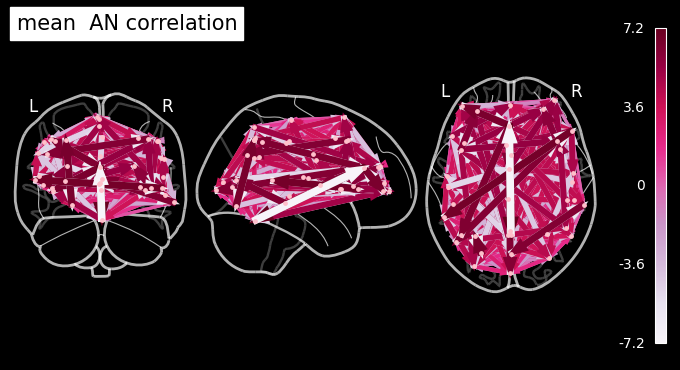

In [27]:
plotting.plot_connectome(
    an_mean_correlations.values,
    msdl['region_coords'],
    title="mean  AN correlation",
    node_color='pink',
    node_size=6,
    edge_cmap='PuRd',
    black_bg=True,
    colorbar=True
)

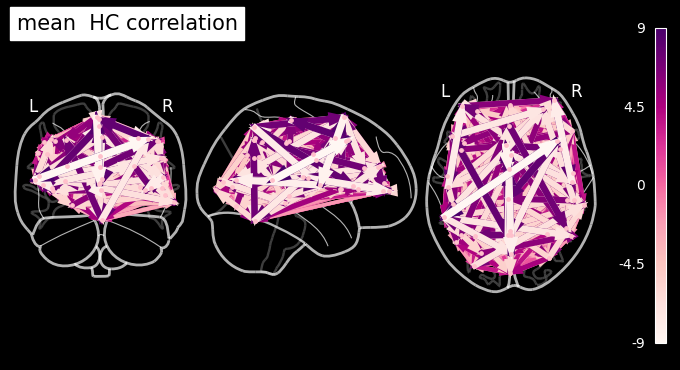

In [28]:
plotting.plot_connectome(
    hc_mean_correlations.values,
    msdl['region_coords'],
    title="mean  HC correlation",
    node_color='pink',
    node_size=6,
    edge_cmap='RdPu',
    black_bg=True,
    colorbar=True
)